##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#### This notebook is created by [Nitin Tiwari](https://linkedin.com/in/tiwari-nitin).

#### **Social links:**
* [LinkedIn](https://linkedin.com/in/tiwari-nitin)
* [GitHub](https://github.com/NSTiwari)
* [Twitter](https://x.com/NSTiwari21)

# Zero-shot Object Detection in images

This notebook guides you to perform zero-shot object detection on images using [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) and draw the inferences using OpenCV and PIL.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/PaliGemma/Zero_shot_object_detection_in_images_using_PaliGemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Hugging Face by completing the following steps:

1. Log in to [Hugging Face](https://huggingface.co), or create a new Hugging Face account if you don't already have one.
2. Go to the [PaliGemma model card](https://huggingface.co/google/paligemma-3b-mix-224) to get access to the model.
3. Complete the consent form and accept the terms and conditions.

To generate a Hugging Face token, open your [**Settings** page in Hugging Face](https://huggingface.co/settings), choose **Access Tokens** option in the left pane and click **New token**. In the next window that appears, give a name to your token and choose the type as **Write** to get the write access.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Hugging Face token. Store your Hugging Face token under the name `HF_TOKEN`.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Step 1: Install libraries

In [ ]:
!pip install bitsandbytes transformers accelerate peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 22.7 MB/s eta 0:00:00


### Step 2: Set environment variables for Hugging Face token

In [ ]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

### Step 3: Load pre-trained PaliGemma base model

In [ ]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16)
processor = PaliGemmaProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

### Step 4: Function to draw inference on images

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import re

def draw_bounding_box(image, coordinates, label, width, height):
    global label_colors
    y1, x1, y2, x2 = coordinates
    y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))

    text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)
    text_width, text_height = text_size

    text_x = x1 + 2
    text_y = y1 - 5

    font_scale = 1
    label_rect_width = text_width + 8
    label_rect_height = int(text_height * font_scale)

    color = label_colors.get(label, None)
    if color is None:
        color = np.random.randint(0, 256, (3,)).tolist()
        label_colors[label] = color

    cv2.rectangle(image, (x1, y1 - label_rect_height), (x1 + label_rect_width, y1), color, -1)

    thickness = 2
    cv2.putText(image, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    return image

### Step 5: Configure the input image and text prompt

In [51]:
from PIL import Image, ImageDraw, ImageFont

input_image = "input_image.jpg" # @param {type: "string"}
input_img = Image.open(input_image)

# Create a copy of the input image.
output_img = np.array(input_img)

prompt = "detect person, car" # @param {type: "string"}

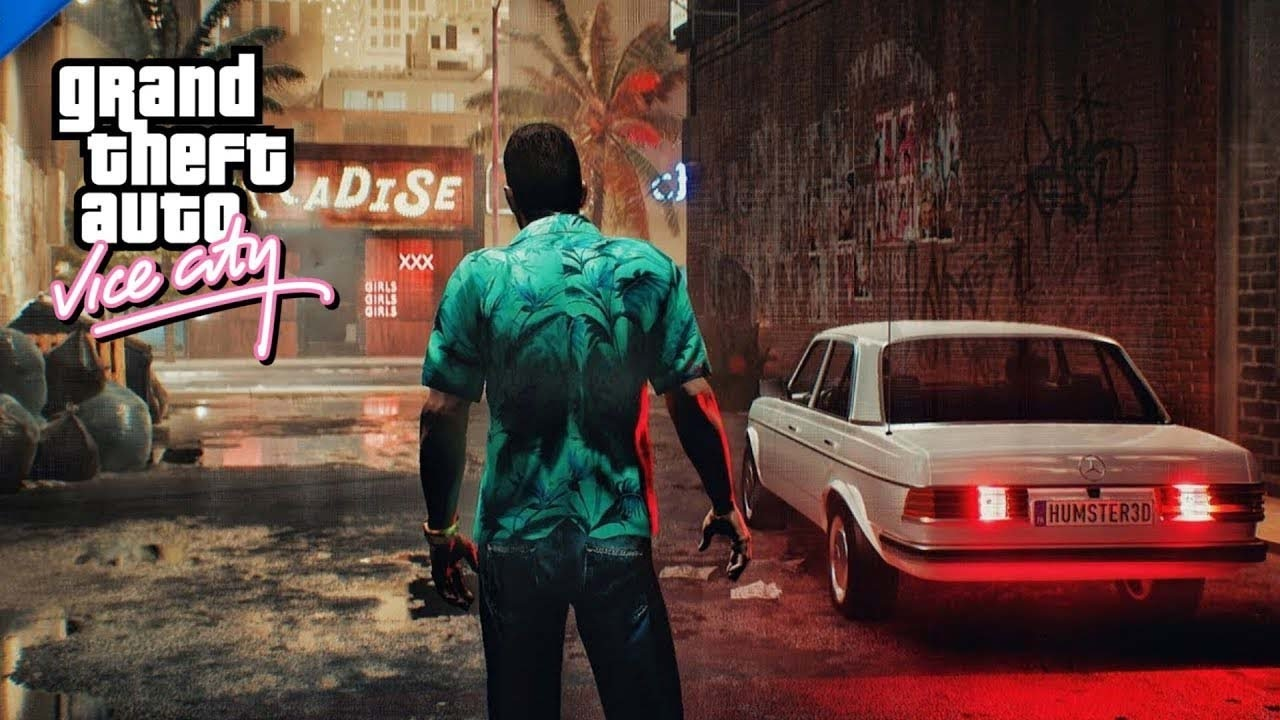

In [52]:
input_img

### Step 6: Pass the input image and text prompt to PaliGemma

In [53]:
inputs = processor(text=prompt, images=input_img,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
model.to(device)
inputs = inputs.to(dtype=model.dtype)

In [54]:
with torch.no_grad():
  output = model.generate(**inputs, max_length=496)

paligemma_response = processor.decode(output[0], skip_special_tokens=True)[len(prompt):].lstrip("\n")

detections = paligemma_response.split(" ; ")

### Step 7: Parse the PaliGemma output
This section parses the response from PaliGemma model and draws the bounding box on image.

In [55]:
parsed_coordinates = []
labels = []
label_colors = {}

for item in detections:
  detection = item.replace("<loc", "").split()

  if len(detection) >= 2:
    coordinates_str = detection[0]
    label = detection[1].replace(",", "")

    if "<seg" in label:
      continue
    else:
      labels.append(label)
  else:
    # No label detected, skip the iteration.
    continue


  coordinates = coordinates_str.split(">")
  coordinates = coordinates[:4]

  if coordinates[-1] == '':
    coordinates = coordinates[:-1]


  coordinates = [int(coord)/1024 for coord in coordinates]
  parsed_coordinates.append(coordinates)

  width = input_img.size[0]
  height = input_img.size[1]

    # Draw bounding boxes on the frame.
  image = cv2.cvtColor(np.array(input_img), cv2.COLOR_RGB2BGR)
  for coordinates, label in zip(parsed_coordinates, labels):
    output_image = draw_bounding_box(output_img, coordinates, label, width, height)

  output_image = Image.fromarray(output_image)

### Step 8: Display the final output

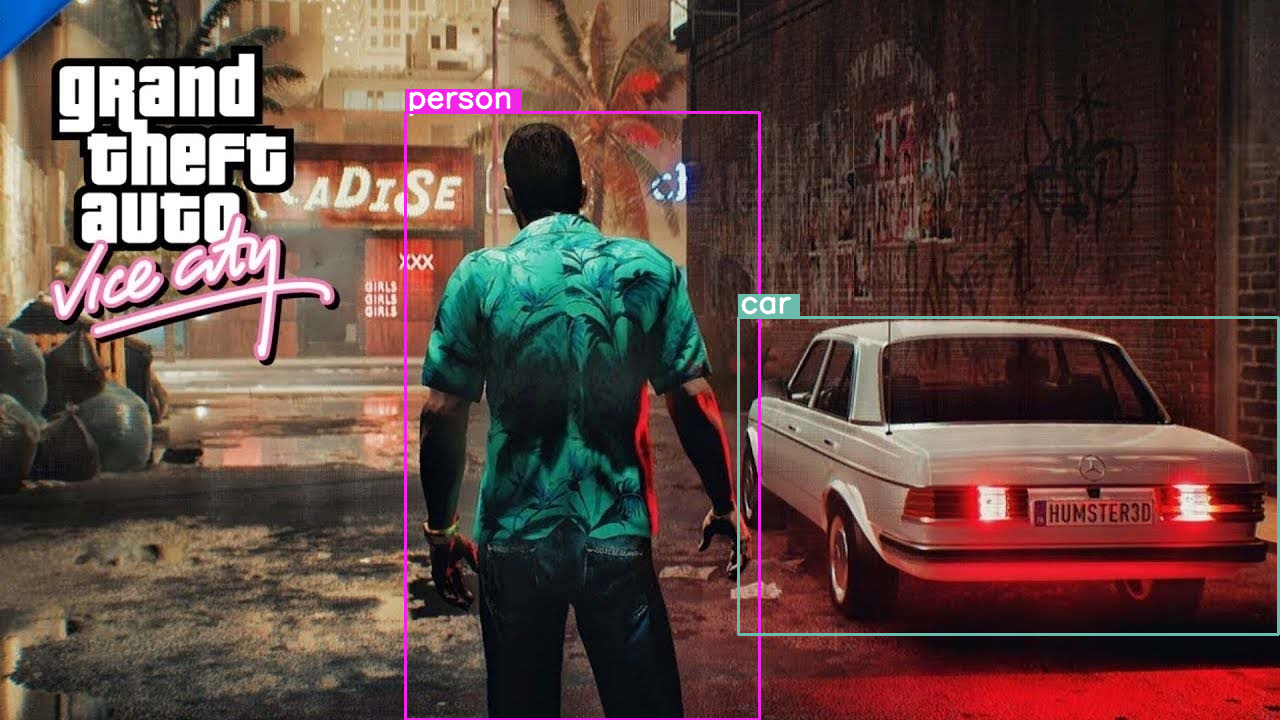

In [56]:
output_image